In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import itertools
from collections import defaultdict
import random
import gym
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from CallCentreEnvironment import CallCenterEnv, CallCenterEnvValueIteration, CallCenterEnvPPO
import time



def plot_history(history):
    num_metrics = len(history.keys())
    num_cols = 2  # Two plots per row
    num_rows = (num_metrics + 1) // num_cols  # Calculate number of rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5 * num_rows))
    axes = axes.flatten()  # Flatten in case of single-row layout

    for idx, (key, values) in enumerate(history.items()):
        values = np.array(values)

        # Handle nested lists by taking mean per episode if necessary
        if isinstance(values[0], list):
            values = np.array([np.mean(v) for v in values])

        # Plot the values
        axes[idx].plot(values, label=key, color='blue', alpha=0.7)
        axes[idx].axhline(np.mean(values), color='red', linestyle='--', label=f"Avg {key}: {np.mean(values):.2f}")

        # Labels and titles
        axes[idx].set_xlabel("Episode")
        axes[idx].set_ylabel(key)
        axes[idx].set_title(key)
        axes[idx].legend()
        axes[idx].grid(True)

    # Hide any unused subplots (if total plots are odd)
    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


def visualize_policy(policy):
    """
    Visualizes the optimal policy as heatmaps for each inquiry type.
    
    Parameters:
    - policy: Dictionary mapping states (queue_junior, queue_senior, inquiry_type) to actions.
    - max_queue_size: Maximum queue length.
    """
    matrix_size = max([i[0] for i in policy.keys()]+ [i[1] for i in policy.keys()]) + 1
    action_matrix_0 = np.full((matrix_size, matrix_size), -1)  # Inquiry type 0 (Basic)
    action_matrix_1 = np.full((matrix_size, matrix_size), -1)  # Inquiry type 1 (Complex)

    # Populate matrices with best actions
    for state, action in policy.items():
        queue_junior, queue_senior, inquiry_type = state
        if inquiry_type == 0:
            action_matrix_0[queue_senior, queue_junior] = action  # Queue sizes as axes
        else:
            action_matrix_1[queue_senior, queue_junior] = action  # Queue sizes as axes

    # Flip matrices vertically for correct orientation
    action_matrix_0 = np.flipud(action_matrix_0)
    action_matrix_1 = np.flipud(action_matrix_1)

    # Plot both matrices
    fig, axes = plt.subplots(1, 2, figsize=(18, 9))

    # Inquiry Type 0 (Basic) Heatmap
    sns.heatmap(action_matrix_0, annot=True, cmap="coolwarm", fmt=".0f", linewidths=0.5, cbar=False, ax=axes[0])
    axes[0].set_xlabel("Queue Size for Staff 0")
    axes[0].set_ylabel("Queue Size for Staff 1")
    axes[0].set_title("Best Action for Inquiry Type 0")
    axes[0].set_xticks(np.arange(matrix_size) + 0.5)
    axes[0].set_yticks(np.arange(matrix_size) + 0.5)
    axes[0].set_xticklabels(np.arange(matrix_size))
    axes[0].set_yticklabels(np.flip(np.arange(matrix_size)))

    # Inquiry Type 1 (Complex) Heatmap
    sns.heatmap(action_matrix_1, annot=True, cmap="coolwarm", fmt=".0f", linewidths=0.5, cbar=False, ax=axes[1])
    axes[1].set_xlabel("Queue Size for 0")
    axes[1].set_ylabel("Queue Size for 1")
    axes[1].set_title("Best Action for Inquiry Type 1")
    axes[1].set_xticks(np.arange(matrix_size) + 0.5)
    axes[1].set_yticks(np.arange(matrix_size) + 0.5)
    axes[1].set_xticklabels(np.arange(matrix_size))
    axes[1].set_yticklabels(np.flip(np.arange(matrix_size)))

    plt.tight_layout()
    plt.show()

def visualize_policy_ppo(env,model):
    # Detect device (CPU or GPU)
    device = model.policy.device

    max_queue_size = env.max_staff_queue

    # Expected state size from the model
    expected_state_size = model.policy.observation_space.shape[0]

    # Generate all possible states (queue sizes for each staff)
    state_space = list(itertools.product(range(max_queue_size + 1), repeat=env.staff_pool_size))

    # Store best actions separately for Inquiry Types 0 and 1
    best_actions_inquiry_0 = []  # Type 1 (Basic)
    best_actions_inquiry_1 = []  # Type 2 (Complex)

    for state in state_space:
        state_0 = list(state)  # Inquiry Type 0 (Basic)
        state_1 = list(state)  # Inquiry Type 1 (Complex)

        # Normalize state (divide queue sizes by max_queue_size, inquiry type remains 0 or 1)
        state_0 = np.array(state_0, dtype=np.float32) / max_queue_size
        state_1 = np.array(state_1, dtype=np.float32) / max_queue_size

        # Construct state representation (only queue sizes + inquiry type)
        state_0 = list(state) + [0]  # Inquiry Type 0 (Basic)
        state_1 = list(state) + [1]  # Inquiry Type 1 (Complex)

        # Convert to PyTorch tensors
        state_tensor_0 = torch.tensor(state_0, device=device).unsqueeze(0)
        state_tensor_1 = torch.tensor(state_1, device=device).unsqueeze(0)

        with torch.no_grad():
            # Get best action for inquiry type 0
            action_distribution_0 = model.policy.get_distribution(state_tensor_0)
            action_probs_0 = torch.softmax(action_distribution_0.distribution.logits, dim=-1).cpu().numpy().flatten()
            best_action_0 = np.argmax(action_probs_0)

            # Get best action for inquiry type 1
            action_distribution_1 = model.policy.get_distribution(state_tensor_1)
            action_probs_1 = torch.softmax(action_distribution_1.distribution.logits, dim=-1).cpu().numpy().flatten()
            best_action_1 = np.argmax(action_probs_1)

        best_actions_inquiry_0.append((state, best_action_0))
        best_actions_inquiry_1.append((state, best_action_1))

    # Convert to matrix representation
    matrix_size = max_queue_size + 1
    action_matrix_0 = np.full((matrix_size, matrix_size), -1)  # Inquiry type 0 (Basic)
    action_matrix_1 = np.full((matrix_size, matrix_size), -1)  # Inquiry type 1 (Complex)

    for (state, action) in best_actions_inquiry_0:
        if len(state) >= 2:
            action_matrix_0[state[1], state[0]] = action  # Queue sizes as axes

    for (state, action) in best_actions_inquiry_1:
        if len(state) >= 2:
            action_matrix_1[state[1], state[0]] = action  # Queue sizes as axes

    # Flip matrices vertically for correct orientation
    action_matrix_0 = np.flipud(action_matrix_0)
    action_matrix_1 = np.flipud(action_matrix_1)

    # Plot both matrices
    fig, axes = plt.subplots(1, 2, figsize=(18, 9))

    # Inquiry Type 0 (Basic) Heatmap
    sns.heatmap(action_matrix_0, annot=True, cmap="coolwarm", fmt=".0f", linewidths=0.5, cbar=False, ax=axes[0])
    axes[0].set_xlabel("Queue Size for Staff 0")
    axes[0].set_ylabel("Queue Size for Staff 1")
    axes[0].set_title("Best Action for Inquiry Type 0")
    axes[0].set_xticks(np.arange(matrix_size) + 0.5)
    axes[0].set_yticks(np.arange(matrix_size) + 0.5)
    axes[0].set_xticklabels(np.arange(matrix_size))
    axes[0].set_yticklabels(np.flip(np.arange(matrix_size)))

    # Inquiry Type 1 (Complex) Heatmap
    sns.heatmap(action_matrix_1, annot=True, cmap="coolwarm", fmt=".0f", linewidths=0.5, cbar=False, ax=axes[1])
    axes[1].set_xlabel("Queue Size for Staff 0")
    axes[1].set_ylabel("Queue Size for Staff 1")
    axes[1].set_title("Best Action for Inquiry Type 1")
    axes[1].set_xticks(np.arange(matrix_size) + 0.5)
    axes[1].set_yticks(np.arange(matrix_size) + 0.5)
    axes[1].set_xticklabels(np.arange(matrix_size))
    axes[1].set_yticklabels(np.flip(np.arange(matrix_size)))

    plt.tight_layout()
    plt.show()


def policy_simulation(env,policy, model_name, num_episodes=1000):
    try:
        with open(f"{model_name}_history.pkl", "rb") as f:
            history = pickle.load(f)
    
    except FileNotFoundError:
        history = dict()
        history['rewards'] = []
        for i in env._system_statistics().keys():
            history[i] = []
        
        history["max_Staff_0"] = []
        history["max_Staff_1"] = []
        
        for episode in range(num_episodes):
            state = env.reset()
            total_reward = 0
            done = False

            while not done:
                state_key = tuple(state.astype(int))  # Ensure only (queue_junior, queue_senior, inquiry_type)
                if state_key in policy:
                    action = policy[state_key]
                else:
                    action = env.action_space.sample() 
                state, reward, done, _ = env.step(action)  # Step the environment
                total_reward += reward  # Accumulate reward

            history["rewards"].append(total_reward)
            result = env._system_statistics()

            for i in result.keys():
                history[i].append(result[i])
            
            enevt_list = env.event_list()
            history["max_Staff_0"].append(max([i["Staff_1"] for i in enevt_list]))
            history["max_Staff_1"].append(max([i["Staff_2"] for i in enevt_list]))

            # if (episode + 1) % 100 == 0:
            #     print(f"Episode {episode + 1}/{num_episodes}")
        with open(f"{model_name}_history.pkl", "wb") as f:
                pickle.dump(dict(history), f)

    return history

def model_simulation(env,model, model_name, num_episodes=1000):
    
    try:
        with open(f"{model_name}_history.pkl", "rb") as f:
            history = pickle.load(f)
    
    except FileNotFoundError:
        history = dict()
        history['rewards'] = []
        for i in env._system_statistics().keys():
            history[i] = []
        
        history["max_Staff_0"] = []
        history["max_Staff_1"] = []
        
        for episode in range(num_episodes):
            state = env.reset()
            total_reward = 0
            done = False

            while not done:
                action, _ = model.predict(state, deterministic=True)
                state, reward, done, _ = env.step(action)  # Step the environment
                total_reward += reward  # Accumulate reward

            history["rewards"].append(total_reward)
            result = env._system_statistics()

            for i in result.keys():
                history[i].append(result[i])
            
            enevt_list = env.event_list()
            history["max_Staff_0"].append(max([i["Staff_1"] for i in enevt_list]))
            history["max_Staff_1"].append(max([i["Staff_2"] for i in enevt_list]))

            # if (episode + 1) % 100 == 0:
            #     print(f"Episode {episode + 1}/{num_episodes}")
        with open(f"{model_name}_history.pkl", "wb") as f:
            pickle.dump(dict(history), f)

    return history

## 1. Random Policy

In [17]:
def random_action_simulation(env, num_episodes=1000):
    try:
        with open(f"random_history.pkl", "rb") as f:
            history = pickle.load(f)
    
    except FileNotFoundError:
        history = dict()
        history['rewards'] = []
        for i in env._system_statistics().keys():
            history[i] = []
        
        history["max_Staff_0"] = []
        history["max_Staff_1"] = []
        
        for episode in range(num_episodes):
            state = env.reset()
            total_reward = 0
            done = False

            while not done:
                action = env.action_space.sample()  # Take a random action
                next_state, reward, done, _ = env.step(action)  # Step the environment
                total_reward += reward  # Accumulate reward

            history["rewards"].append(total_reward)
            result = env._system_statistics()

            for i in result.keys():
                history[i].append(result[i])
            
            enevt_list = env.event_list()
            history["max_Staff_0"].append(max([i["Staff_1"] for i in enevt_list]))
            history["max_Staff_1"].append(max([i["Staff_2"] for i in enevt_list]))

        
        with open(f"random_history.pkl", "wb") as f:
                pickle.dump(dict(history), f)

    return history


In [18]:
fundenamental_env = CallCenterEnv(staff_pool_size = 2, time_until=28800, arrival_rate=[100,120], service_rate=[[120, 190], [150,170]], abandonment_rate=[300, 400], max_staff_queue = 14, random_run=True)
random_history = random_action_simulation(fundenamental_env, 1000)
# plot_history(random_history)

## 2. Simulation System Exploration 

In [19]:
def plot_lln(history, key="total_clients"):
    values = history[key]
    cumulative_means = [np.mean(values[:i+1]) for i in range(len(values))]  # Compute cumulative mean

    plt.figure(figsize=(10, 5))
    plt.plot(range(len(values)), cumulative_means, label="Cumulative Mean", color="blue", alpha=0.7)
    plt.axhline(np.mean(values), color="red", linestyle="--", label=f"Final Mean: {np.mean(values):.2f}")

    # Labels and title
    plt.xlabel("Episode")
    plt.ylabel("Mean of " + key)
    plt.title(f"Mean of {key} over Episodes")
    plt.legend()
    plt.grid(True)

    plt.show()

### 2.1. Number of Episodes for Evaluation

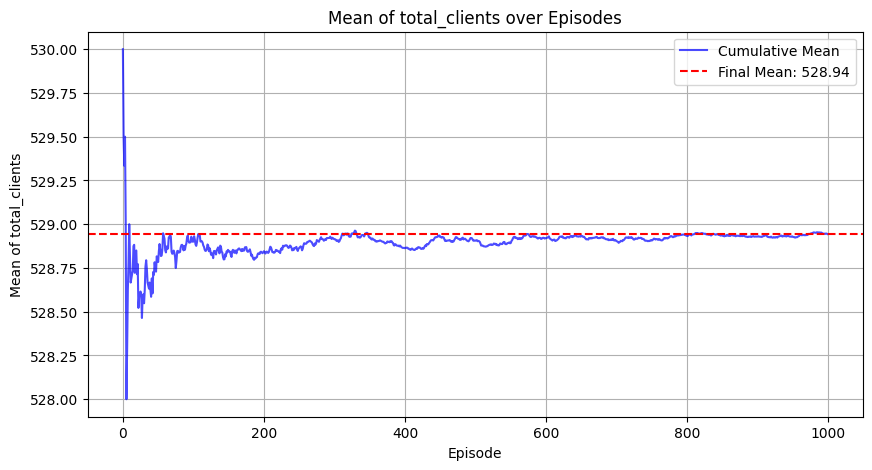

In [20]:
plot_lln(random_history, key="total_clients")

### 2.2. Staff Queue Length Configuration

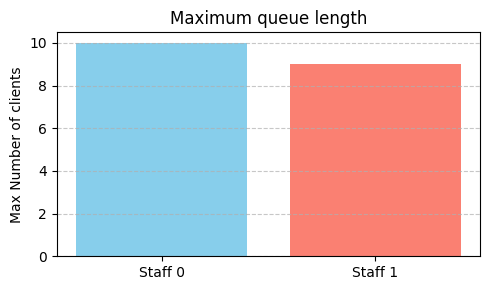

In [21]:
max_staff_queue = [max(random_history["max_Staff_0"]), max(random_history["max_Staff_1"])]
labels = ["Staff 0", "Staff 1"]

plt.figure(figsize=(5, 3))
bars = plt.bar(labels, max_staff_queue, color=['skyblue', 'salmon'])


plt.ylabel('Max Number of clients')
plt.title('Maximum queue length')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 2.3. Penalty Constant for Reward Function

In [22]:
sum(random_history["mean_waiting_time"])/len(random_history["mean_waiting_time"])

126.56879223222307

## 3. Value Iteration

In [23]:
def value_iteration(env, gamma=0.9, theta=1e-6, max_iterations=100000, file_name="value_iteration"):
    save_file = f"{file_name}.pkl"
    possible_states = list(itertools.product(range(env.max_staff_queue+1), range(env.max_staff_queue+1), [0, 1]))
    n_actions = env.action_space.n

    def extract_policy(V):
        policy = {}
        for state in env.P_dict:
            best_action = None
            best_value = float("-inf")

            for action in range(n_actions):
                q = 0
                for prob, next_state, reward in env.P(state, action):
                    # q += prob * (reward + gamma * V[next_state])
                    q += reward + gamma * (prob *V[next_state])

                if q > best_value:
                    best_value = q
                    best_action = action

            policy[state] = best_action
        return policy

    # Try to load saved Value Function & Policy
    if os.path.exists(save_file):
        with open(save_file, "rb") as f:
            data = pickle.load(f)
            V = data["V"]
            best_policy = data["policy"]
            reward_history = data["vi_reward_history"]
    else:
        V = {s: 0 for s in possible_states}  # Initialize Value Function
        policy = {s: 0 for s in possible_states}  # Initialize Policy
        reward_history = []

        for i in range(max_iterations):
            delta = 0
            

            for state in env.P_dict:
                v = V[state]
                action_values = []

                for action in [0, 1]:
                    q = 0
                    for prob, next_state, reward in env.P(state, action):
                        # q += prob * (reward + gamma * V[next_state])
                        q += reward + gamma * (prob *V[next_state])
                    action_values.append(q)

                # Bellman optimality update
                V[state] = max(action_values)
                delta = max(delta, abs(v - V[state]))

            if delta < theta:
                print(f"Value iteration converged in {i} iterations.")
                break
        else:
            print("Value iteration did not fully converge.")

        best_policy = extract_policy(V)

        # Save results
        with open(save_file, "wb") as f:
            pickle.dump({"V": V, "policy": best_policy, "vi_reward_history": reward_history}, f)
    
    return best_policy, V, reward_history

### 3.1. Vale Iteration training

In [24]:
vi_training_time = 'vi_training_time.pkl'

if os.path.exists(vi_training_time):
    # If file exists, load the training time
    with open(vi_training_time, 'rb') as f:
        elapsed_time = pickle.load(f)
    print(f"Training time: {elapsed_time:.2f} seconds")
else:
    # If file doesn't exist, run training and save the time
    start_time = time.time()
    
    VI_env = CallCenterEnvValueIteration(staff_pool_size = 2, time_until=28800, arrival_rate=[100,120], service_rate=[[120, 190], [150,170]], abandonment_rate=[300, 400], max_staff_queue= 14, random_run=True)
    value_iteration_policy, v, vi_reward_history = value_iteration(VI_env)

    end_time = time.time()
    elapsed_time = end_time - start_time

    with open(vi_training_time, 'wb') as f:
        pickle.dump(elapsed_time, f)
    print(f"Training time: {elapsed_time:.2f} seconds")

Training time: 0.11 seconds


## 4. PPO

### 4.1. PPO training

In [25]:
# Create PPO model
PPO_env = CallCenterEnvPPO(staff_pool_size = 2, time_until=28800, arrival_rate=[100,120], service_rate=[[120, 190], [150,170]], abandonment_rate=[300, 400], max_staff_queue= 14, random_run=True)
PPO_eval_env = CallCenterEnvPPO(staff_pool_size = 2, time_until=28800, arrival_rate=[100,120], service_rate=[[120, 190], [150,170]], abandonment_rate=[300, 400], max_staff_queue= 14, random_run=True)


PPO_training_time = 'PPO_training_time.pkl'

if os.path.exists(PPO_training_time):
    # If file exists, load the training time
    with open(PPO_training_time, 'rb') as f:
        elapsed_time = pickle.load(f)
    print(f"Training time: {elapsed_time:.2f} seconds")
else:
    # If file doesn't exist, run training and save the time
    start_time = time.time()
    
    # Define the evaluation callback
    eval_callback = EvalCallback(
        PPO_eval_env,
        best_model_save_path='./best_model/',
        log_path='./logs/',
        eval_freq=10000,                 # Evaluate every 10,000 steps
        deterministic=True,
        render=False
    )

    # Initialize PPO model
    model = PPO(
        "MlpPolicy",
        PPO_env,
        verbose=1,
        learning_rate=0.0003,
        n_steps=2048,
        batch_size=64,
        ent_coef=0.01,
        tensorboard_log="./ppo_logs/"
    )

    # Train the model with the evaluation callback
    model.learn(
        total_timesteps=4000000,
        callback=eval_callback
    )

    # Save the final model
    model.save("ppo_call_center")

    end_time = time.time()
    elapsed_time = end_time - start_time

    with open(PPO_training_time, 'wb') as f:
        pickle.dump(elapsed_time, f)
    print(f"Training time: {elapsed_time:.2f} seconds")




Training time: 2475.48 seconds


### 4.2. Visualize PPO training data

In [26]:
# !tensorboard --logdir=ppo_logs

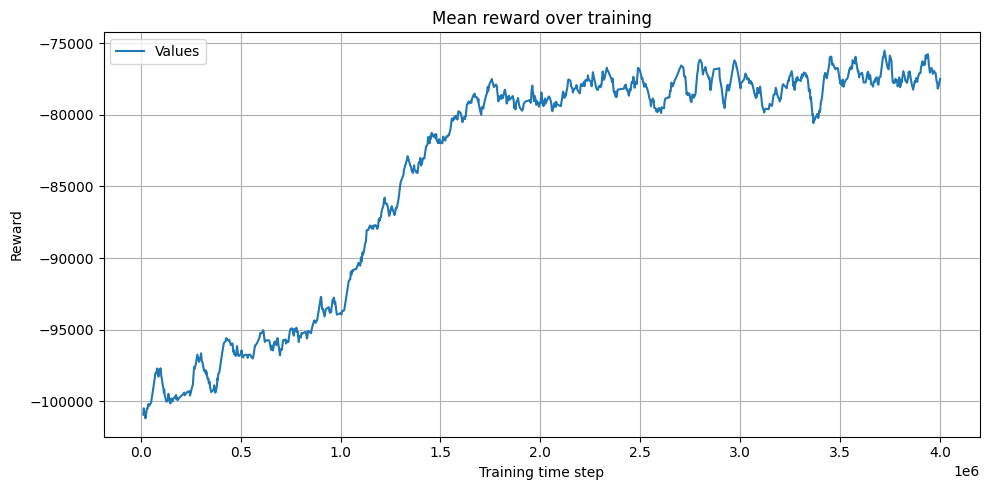

In [27]:
reward_history = pd.read_csv("PPO_1.csv")
plt.figure(figsize=(10, 5))
plt.plot(reward_history["Step"], reward_history["Value"], label='Values', linewidth=1.5)
plt.xlabel('Training time step')
plt.ylabel('Reward')
plt.title('Mean reward over training') 
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



## 5. Policy Evaluation and Policy best action visualisation 

- Using simulation model
- 1000 runs simualtion


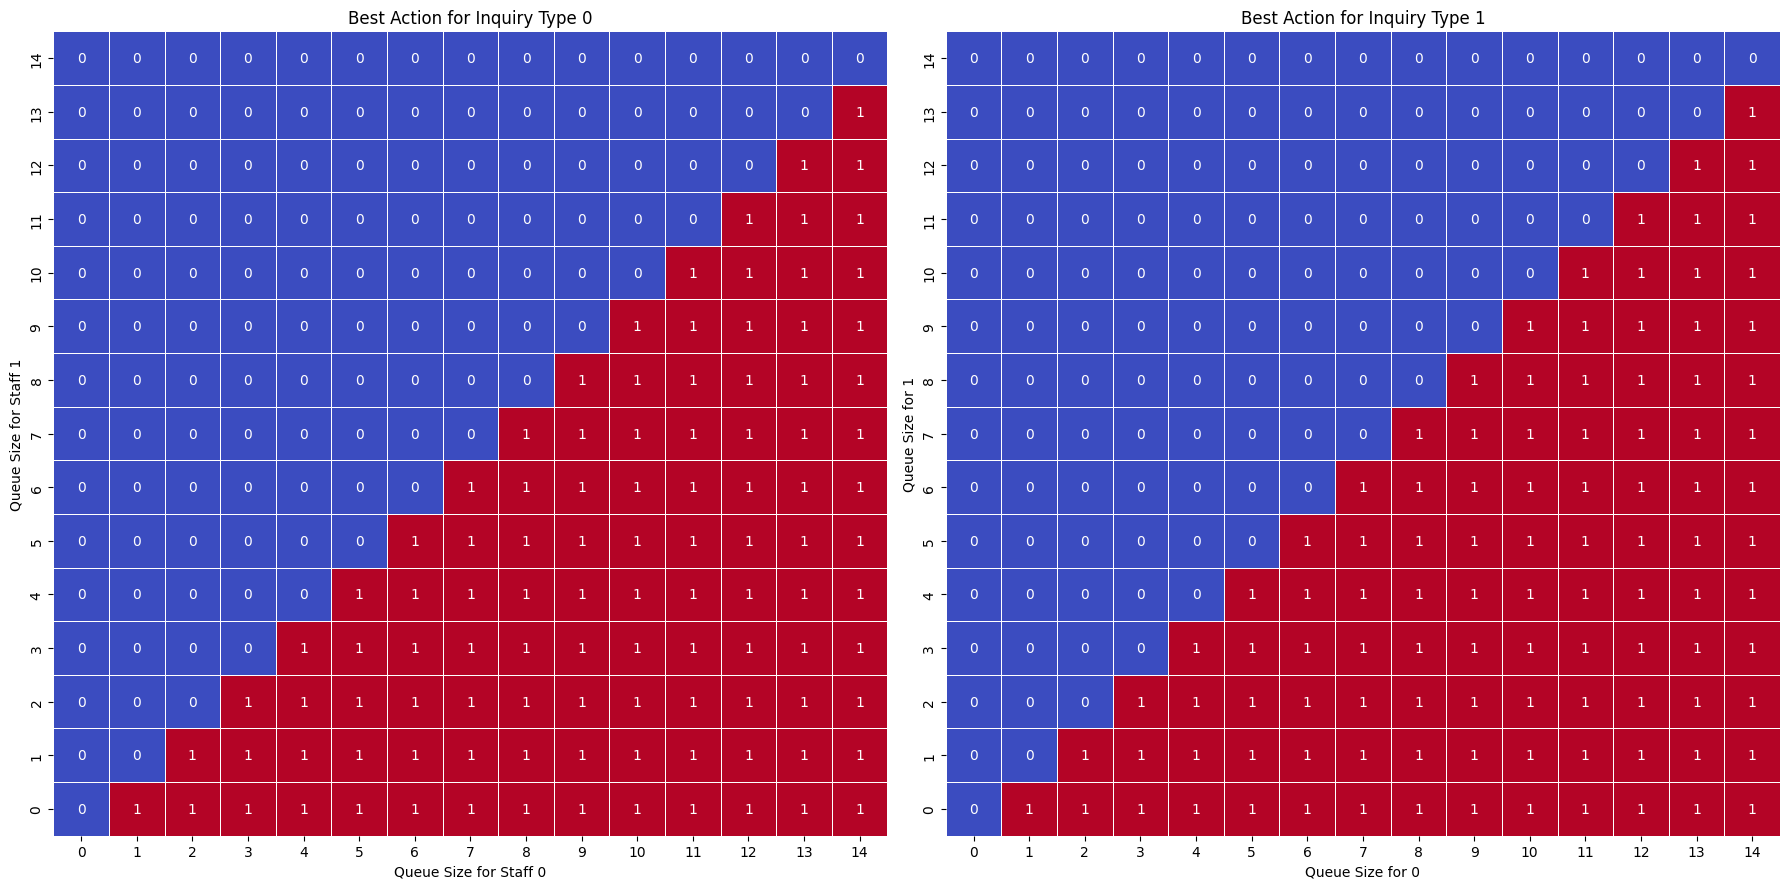

In [28]:
# Create the environment
VI_env = CallCenterEnvValueIteration(staff_pool_size = 2, time_until=28800, arrival_rate=[100,120], service_rate=[[120, 190], [150,170]], abandonment_rate=[300, 400], max_staff_queue= 14, random_run=True)
value_iteration_policy, v, vi_reward_history = value_iteration(VI_env)
value_iteration_history = policy_simulation(VI_env, value_iteration_policy, "value_iteration")
visualize_policy(value_iteration_policy)

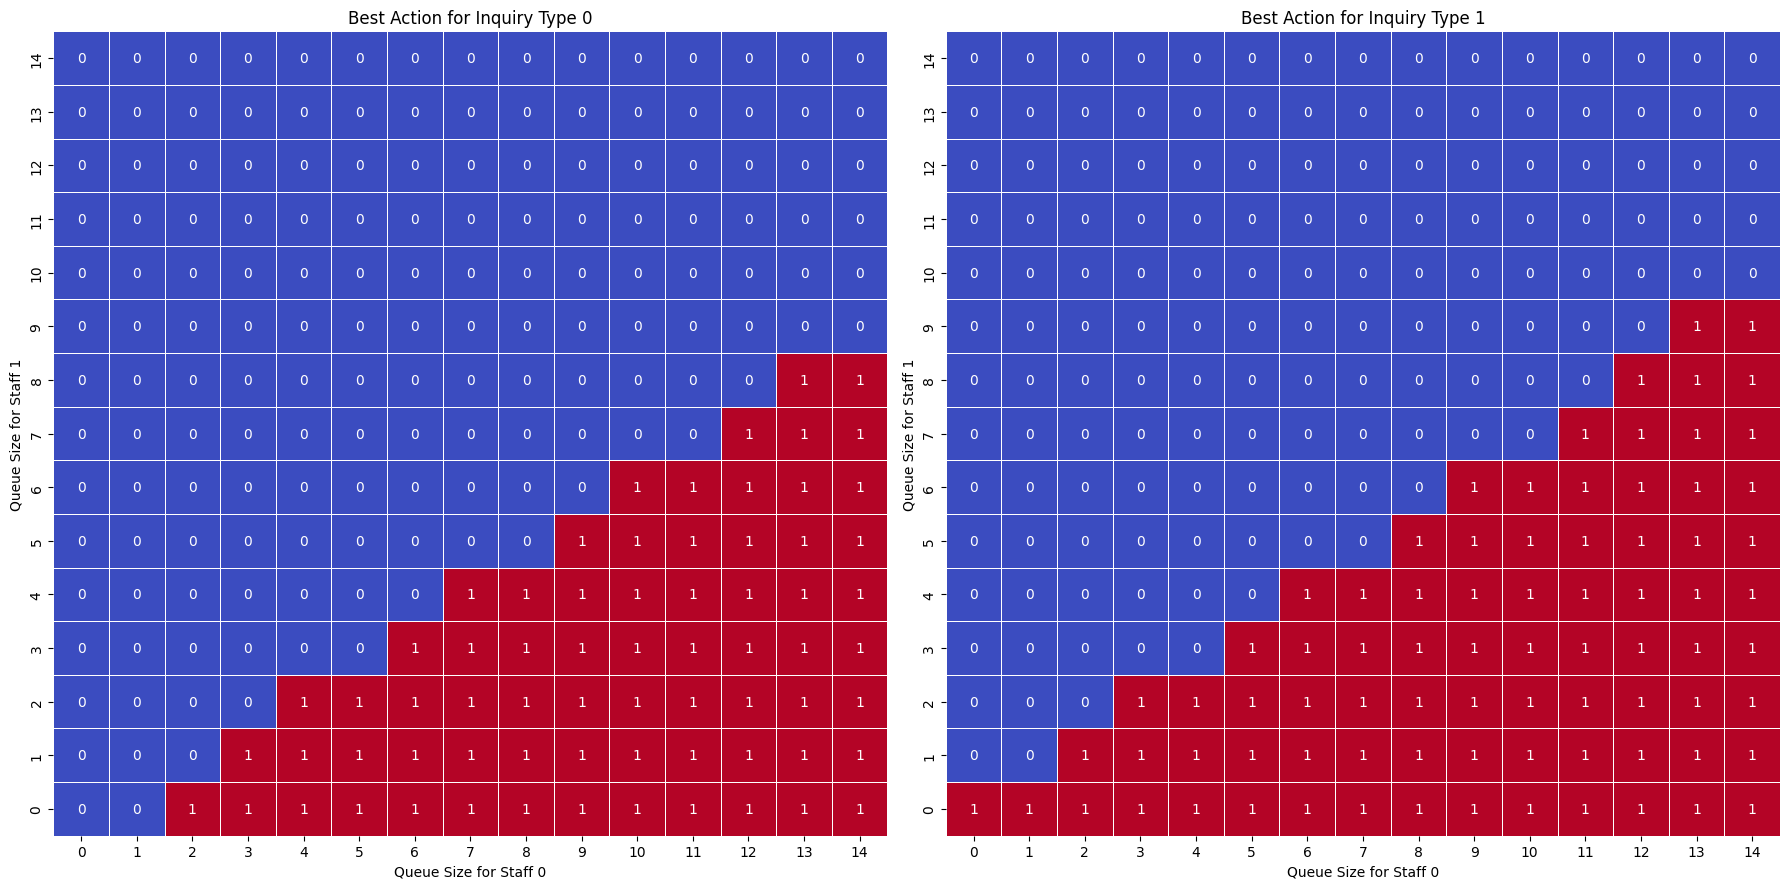

In [29]:
model = PPO.load("ppo_call_center")
PPO_history = model_simulation(PPO_env,model, "ppo")
visualize_policy_ppo(PPO_env ,model)

## 6. Result

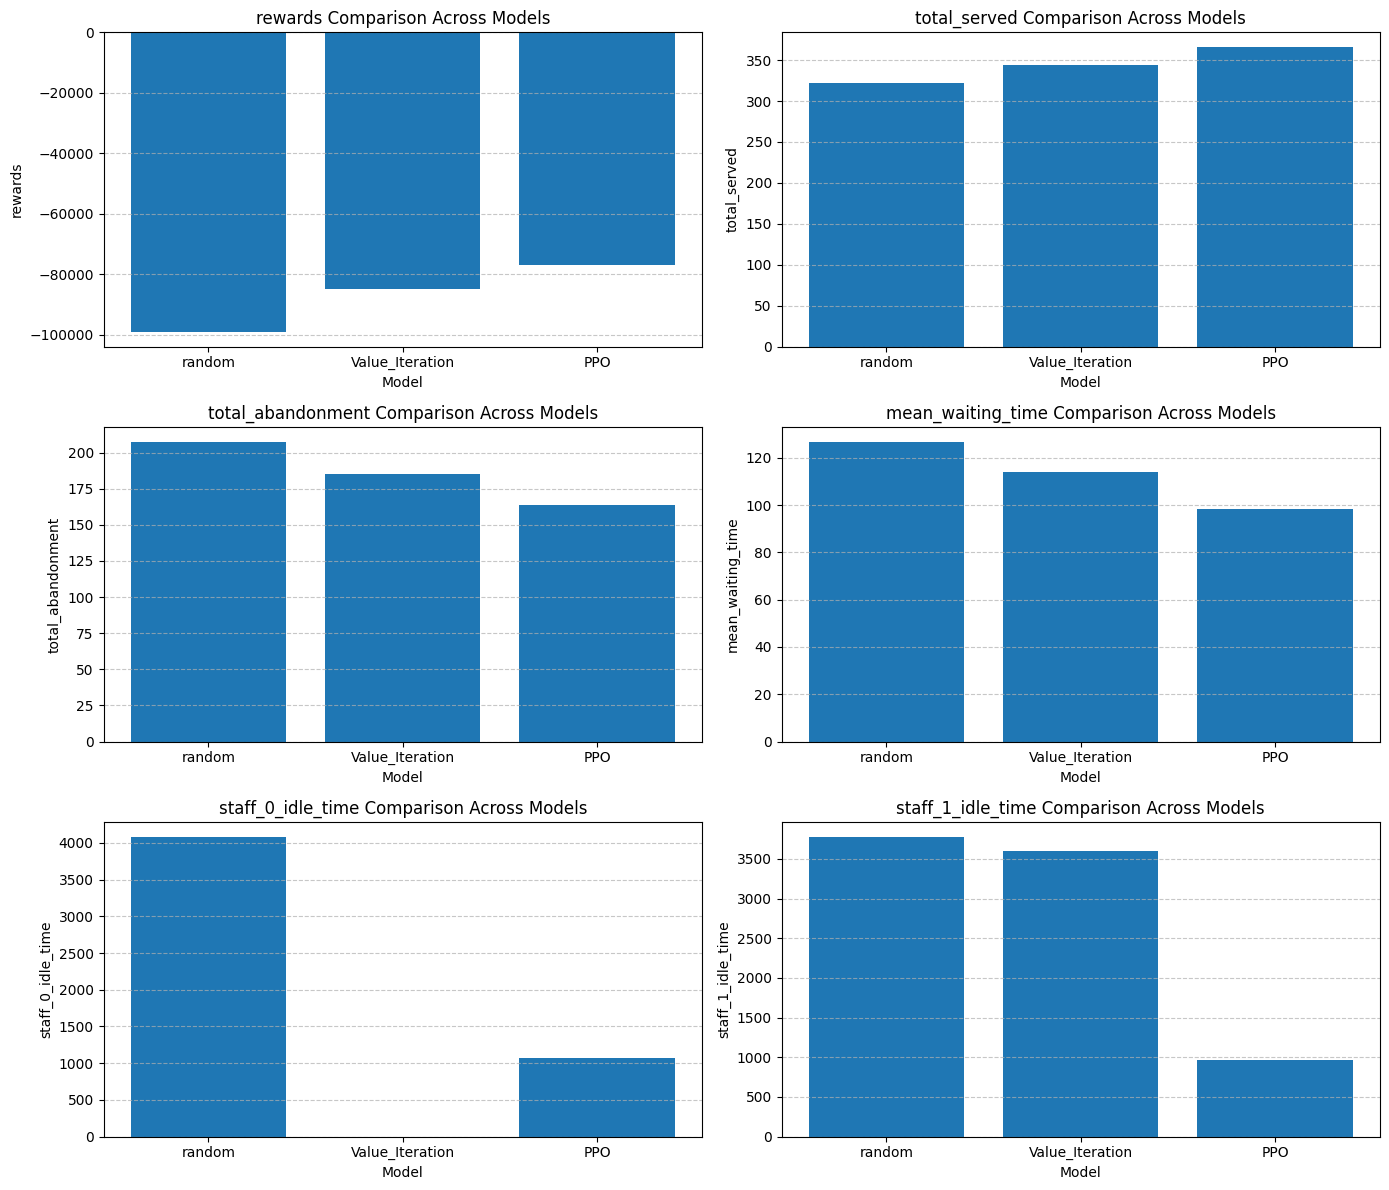

In [30]:
# Store histories in a dictionary with a better name
history_data = {
    "random": random_history,
    "Value_Iteration": value_iteration_history,
    # 'Q_Learning':q_learning_history,
    "PPO": PPO_history
}

# Compute mean values for each metric
all_history = {}
for metric in random_history.keys():  # Assuming all models share the same metric keys
    if metric == 'rewards' or metric == 'total_served' or metric == 'total_abandonment' or metric == 'mean_waiting_time' or metric == 'max_waiting_time' or metric == 'mean_service_time' or metric == 'max_service_time'  or metric == 'staff_0_idle_time' or metric == 'staff_1_idle_time' :
        try:
            all_history[metric] = [
                np.mean(history_data[model][metric]) for model in history_data
            ]
        except KeyError:
            print(f"Warning: Missing metric '{metric}' in some models.")

# Labels for x-axis (models)
labels = list(history_data.keys())
x = np.arange(len(labels))  # X-axis positions

# Number of subplots
num_metrics = len(all_history)
num_cols = 2
num_rows = (num_metrics + num_cols - 1) // num_cols  # Round up

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, num_rows * 4))
axes = axes.flatten()  # Flatten for easy iteration

# Plot each metric in a subplot
for i, (metric, values) in enumerate(all_history.items()):
    axes[i].bar(x, values, tick_label=labels)
    axes[i].set_xlabel("Model")
    axes[i].set_ylabel(metric)
    axes[i].set_title(f"{metric} Comparison Across Models")
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


In [35]:
result_df = pd.DataFrame(all_history).T
result_df.columns = ['Random', 'VI', 'PPO'] 
result_df


,Random,VI,PPO
rewards,-98900.182953,-84742.104968,-76892.410034
total_served,321.838000,343.698000,365.695000
total_abandonment,207.106000,185.320000,163.371000
mean_waiting_time,126.568792,114.200958,98.358532
staff_0_idle_time,4077.600776,0.000000,1063.838513
staff_1_idle_time,3771.353959,3599.618375,967.652348


## 7. Manual Play

In [ ]:
# if __name__ == '__main__':

#     env = CallCenterEnv(random_run=False)
#     obs = env.reset()
#     done = False
#     reward_sum = 0
#     print(f"State: {obs}")
#     while not done:
#         env.render()
#         action = int(input("Enter an action (0 to num_staff or -1 to skip): "))
#         if action == -1:
#             print("Exiting the manual test.")
#             break

#         obs, reward, done, _ = env.step(action)
#         reward_sum += reward
#         print(f"Reward: {reward_sum}\n")
#         print(f"State: {obs}")
#         print("-" * 50)
#     print("Simulation ended.")

In [ ]:
# pd.DataFrame(env.event_list()).to_csv("demo_event_list.csv")